#프로젝트 목표

데이터셋을 사용하여 머신러닝 모델을 만든 후 성능 및 인사이트를 도출 / 공유해본다.

데이터 출처: Dacon - [심리 성향 예측 AI 경진대회](https://www.dacon.io/competitions/official/235647/data)

데이터 셋 선정
- 부트캠프 내 데이터셋이 아닌 다른 데이터셋을 활용하였다.

문제 정의
- 부트캠프 내 문제가 아닌 다른 문제를 정의하고 데이터셋으로부터 문제 정의 과정을 제시하였다.
- 문제 정의에 따른 적절한 타겟을 설정하였다.

EDA&전처리
- 데이터 분석 과정과 결과를 설명하였다.
- 데이터를 살펴보고 전처리를 한 과정이 드러나 있다.

Part 2

모델 학습 및 검증
- 모델링 이전에 미리 baseline 모델을 선정하였다.
- 문제 정의에서 언급한 회귀 / 분류 문제에 맞는 모델을 선택하였다.
- 회귀/분류 문제에 따른 적절한 평가지표를 선택하였다.
- 교차검증이나 hold-out을 사용해 데이터셋을 분리하고 모델의 일반화 성능을 검증하였다.
- 모델 최적화를 위한 하이퍼파라미터 튜닝을 진행하였다.

모델 해석
- 모델 결과로서 Test Score를 제시하여 모델을 평가하였다.
- PDP/SHAP/FeatureImportance 등을 활용하여 모델 작동을 설명하였다.
- 모델 학습 결과에 대한 해석이 드러나 있다. (가설 해소 혹은 문제 해결 등)

## Setup

이번 프로젝트에서 사용된 라이브러리 및 기타 전처리 과정을 정리했다.

In [ ]:
#깃헙일 때 한번 실행하는 코드입니다.
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!unzip -qq "drive/MyDrive/Colab Notebooks/vote_predict_data.zip"

In [ ]:
!pip install category_encoders
!pip install shap
!pip install pdpbox
!pip install eli5
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdpbox.pdp as pdp
import shap
import eli5

from category_encoders import OrdinalEncoder, TargetEncoder
from eli5.sklearn import PermutationImportance
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

#데이터 선정 이유 및 문제 정의

- 해결하고자 하는 문제가 적용되는 시나리오를 제시합니다.
- 문제 해결의 필요성에 대해 명확히 제시합니다.
- 데이터셋 선정이 끝났다면 어떤 유형의 문제로 (분류 / 회귀) 접근할지도 결정합니다.
- 데이터셋에서 해결하고자 하는 문제 정의에 적절한 타겟을 선정합니다.
- 타겟을 잘 설명할 수 있을 만한 특성에 대한 가설을 설정합니다.

## 파일 불러오기

프로젝트에 사용하는 파일을 불러온다.

In [3]:
train = pd.read_csv('open data/train.csv',  index_col= 'index')
test  = pd.read_csv('open data/test_x.csv', index_col= 'index')
train.drop('voted', axis=1, inplace=True)

train.shape, test.shape

((45532, 76), (11383, 76))

타겟 데이터를 정의하고 이를 확인합니다. 이번 문제는 분류 문제에 해당됩니다.

In [4]:
def split_Xy(df:pd.DataFrame):
  target_col = 'age_group'
  
  y = df[target_col]
  X = df.drop(target_col, axis= 1)

  return X, y

In [5]:
X_train, y_train = split_Xy(train)
X_test,  y_test  = split_Xy(test)

In [6]:
X_train.dtypes[X_train.dtypes=='object'].index

Index(['gender', 'race', 'religion'], dtype='object')

In [7]:
print(y_train.value_counts())
print('\nThe number of youngsters:',
      y_train.value_counts()[['20s','10s']].sum() /y_train.shape[0])

10s     14215
20s     14112
30s      7836
40s      5051
50s      2889
60s      1194
+70s      235
Name: age_group, dtype: int64

The number of youngsters: 0.6221338838618993


#EDA


- 머신러닝에 적합한 형태로 데이터 타입을 변경합니다.
- 여러 테크닉을 사용해 결측치를 적절히 처리합니다.
- 본인의 전처리 과정에 대해 근거를 들어 설명합니다.
- 피쳐의 분포를 확인하고 이상치를 적절히 제거합니다.
- 1에서 세운 가설과 관련한 시각화 결과를 제시합니다.

## 사용자 정의 함수

해당 파트에서 사용한 사용자 정의 함수 입니다.

In [8]:
def find_contains(lst, cols):
  return lst[lst.str.contains(cols)]

def convert_feature(X:pd.DataFrame):
  cols = X.columns

  X.loc[X['familysize'] > 11,'familysize'] = 11

  for col in cols[cols.str.startswith('tp')]:
    X[col] = 7 - X[col]\

  return X

def convert_target(target:pd.Series):
  return pd.Series(
      np.where(target.str.contains('20s|10s'),1,0),
      index=target.index, name='YB')

def grid_heatmap(idx:pd.Series, col:pd.Series):
  idx_count = idx.value_counts().sort_index()
  concat  = pd.concat([idx, col], axis=1)
  crossed = pd.crosstab(concat.iloc[:,0], concat.iloc[:,1])
  for idx in crossed.index:
    crossed.loc[idx,:] /= idx_count[idx]
  return sns.heatmap(crossed)

def grid_bar(idx:pd.Series, col:pd.Series):
  i_name = idx.name
  c_name = col.name
  return sns.barplot(
    data=pd.crosstab(idx, col).reset_index().melt(i_name,var_name=c_name),
    x=i_name, y='value', hue=c_name)

def clue_QA(X:pd.DataFrame, y:pd.Series):
  cols = find_contains(X.columns, 'Q*A')

  plt.figure(figsize=(32,30))
  for i, col in enumerate(cols):
    plt.subplot(5,4,i+1)
    grid_bar(X[col], y)
  plt.legend();
  
def clue_tp(X:pd.DataFrame, y:pd.Series):
  cols = X.columns[X.columns.str.startswith('tp')]

  plt.figure(figsize=(16,30))
  for i, col in enumerate(cols):
    plt.subplot(5,2,i+1)
    grid_bar(X[col], y)
  plt.legend();

def clue_corr(X:pd.DataFrame, y:pd.Series, cols=None):
  feature = None
  if cols == None: feature = X.columns
  else:
    feature = find_contains(X.columns, cols)
  df = pd.merge(X[feature], y, left_index=True, right_index=True)
  return sns.heatmap(df.corr())

def split_undersample(X:pd.DataFrame, y:pd.Series):
  false_idx = y[y==0].index
  true_idx  = y[y==1].index

  X_use, X_dummy, y_use, y_dummy = train_test_split(
      X.loc[true_idx,:], y[true_idx],
      train_size = 0.7, test_size=0.3, random_state=42
  )

  return pd.concat([X_use,X.loc[false_idx,:]]), X_dummy, pd.concat([y_use,y[false_idx]]), y_dummy

##본론

In [9]:
X_train_proceed = convert_feature(X_train)
y_train_proceed = convert_target(y_train)
X_test_proceed = convert_feature(X_test)
y_test_proceed = convert_target(y_test)

In [10]:
pd.merge(y_train_proceed, X_train_proceed, left_index=True, right_index=True).groupby('YB').mean().T

YB,0,1
QaA,2.245045,2.059378
QaE,1103.638303,849.221591
QbA,2.530543,3.131571
QbE,2217.587097,2172.583083
QcA,3.545423,3.733364
...,...,...
wr_09,0.284162,0.153423
wr_10,0.962220,0.936315
wr_11,0.530950,0.312740
wr_12,0.967044,0.935997


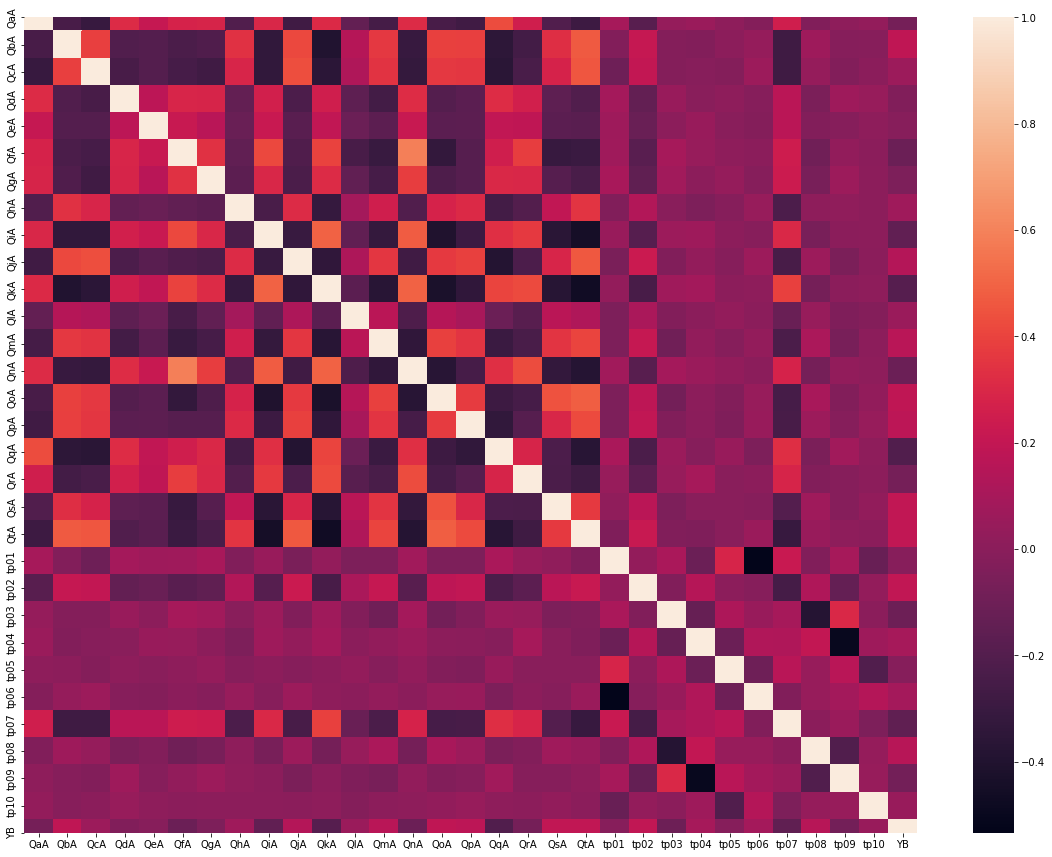

In [11]:
plt.figure(figsize=(20,15))
clue_corr(X_train_proceed, y_train_proceed, 'Q*A|tp');

QA 그룹

1. QaA, QdA, QeA, QfA, QgA, QiA, QkA, QnA, QqA, QrA, tp07
1. QbA, QcA, QhA, QjA, QlA, QmA, QoA, QpA, QsA, QtA, tp02, target

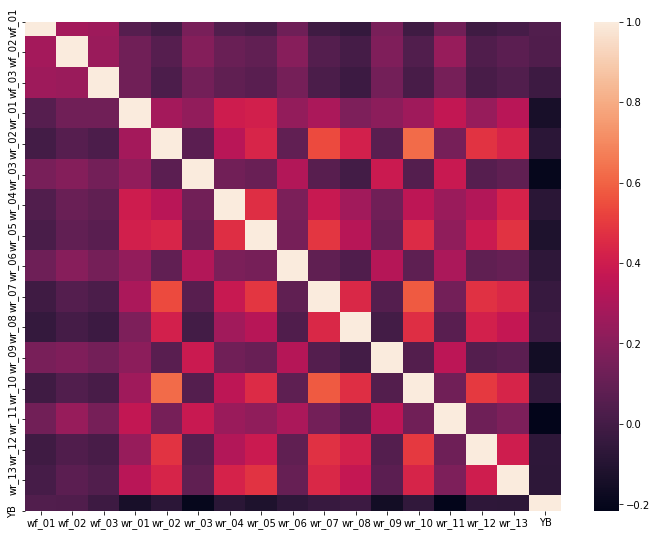

In [12]:
plt.figure(figsize=(12,9))
clue_corr(X_train_proceed, y_train_proceed, 'wf|wr');

wr, wf 그룹

1. wr_01, wr_02, wr_04, wr_05, wr_07, wr_08, wr_10, wr_12, wr_13
1. wf_01, wf_02, wf_03, wr_03, wr_06, wr_09, wr_11

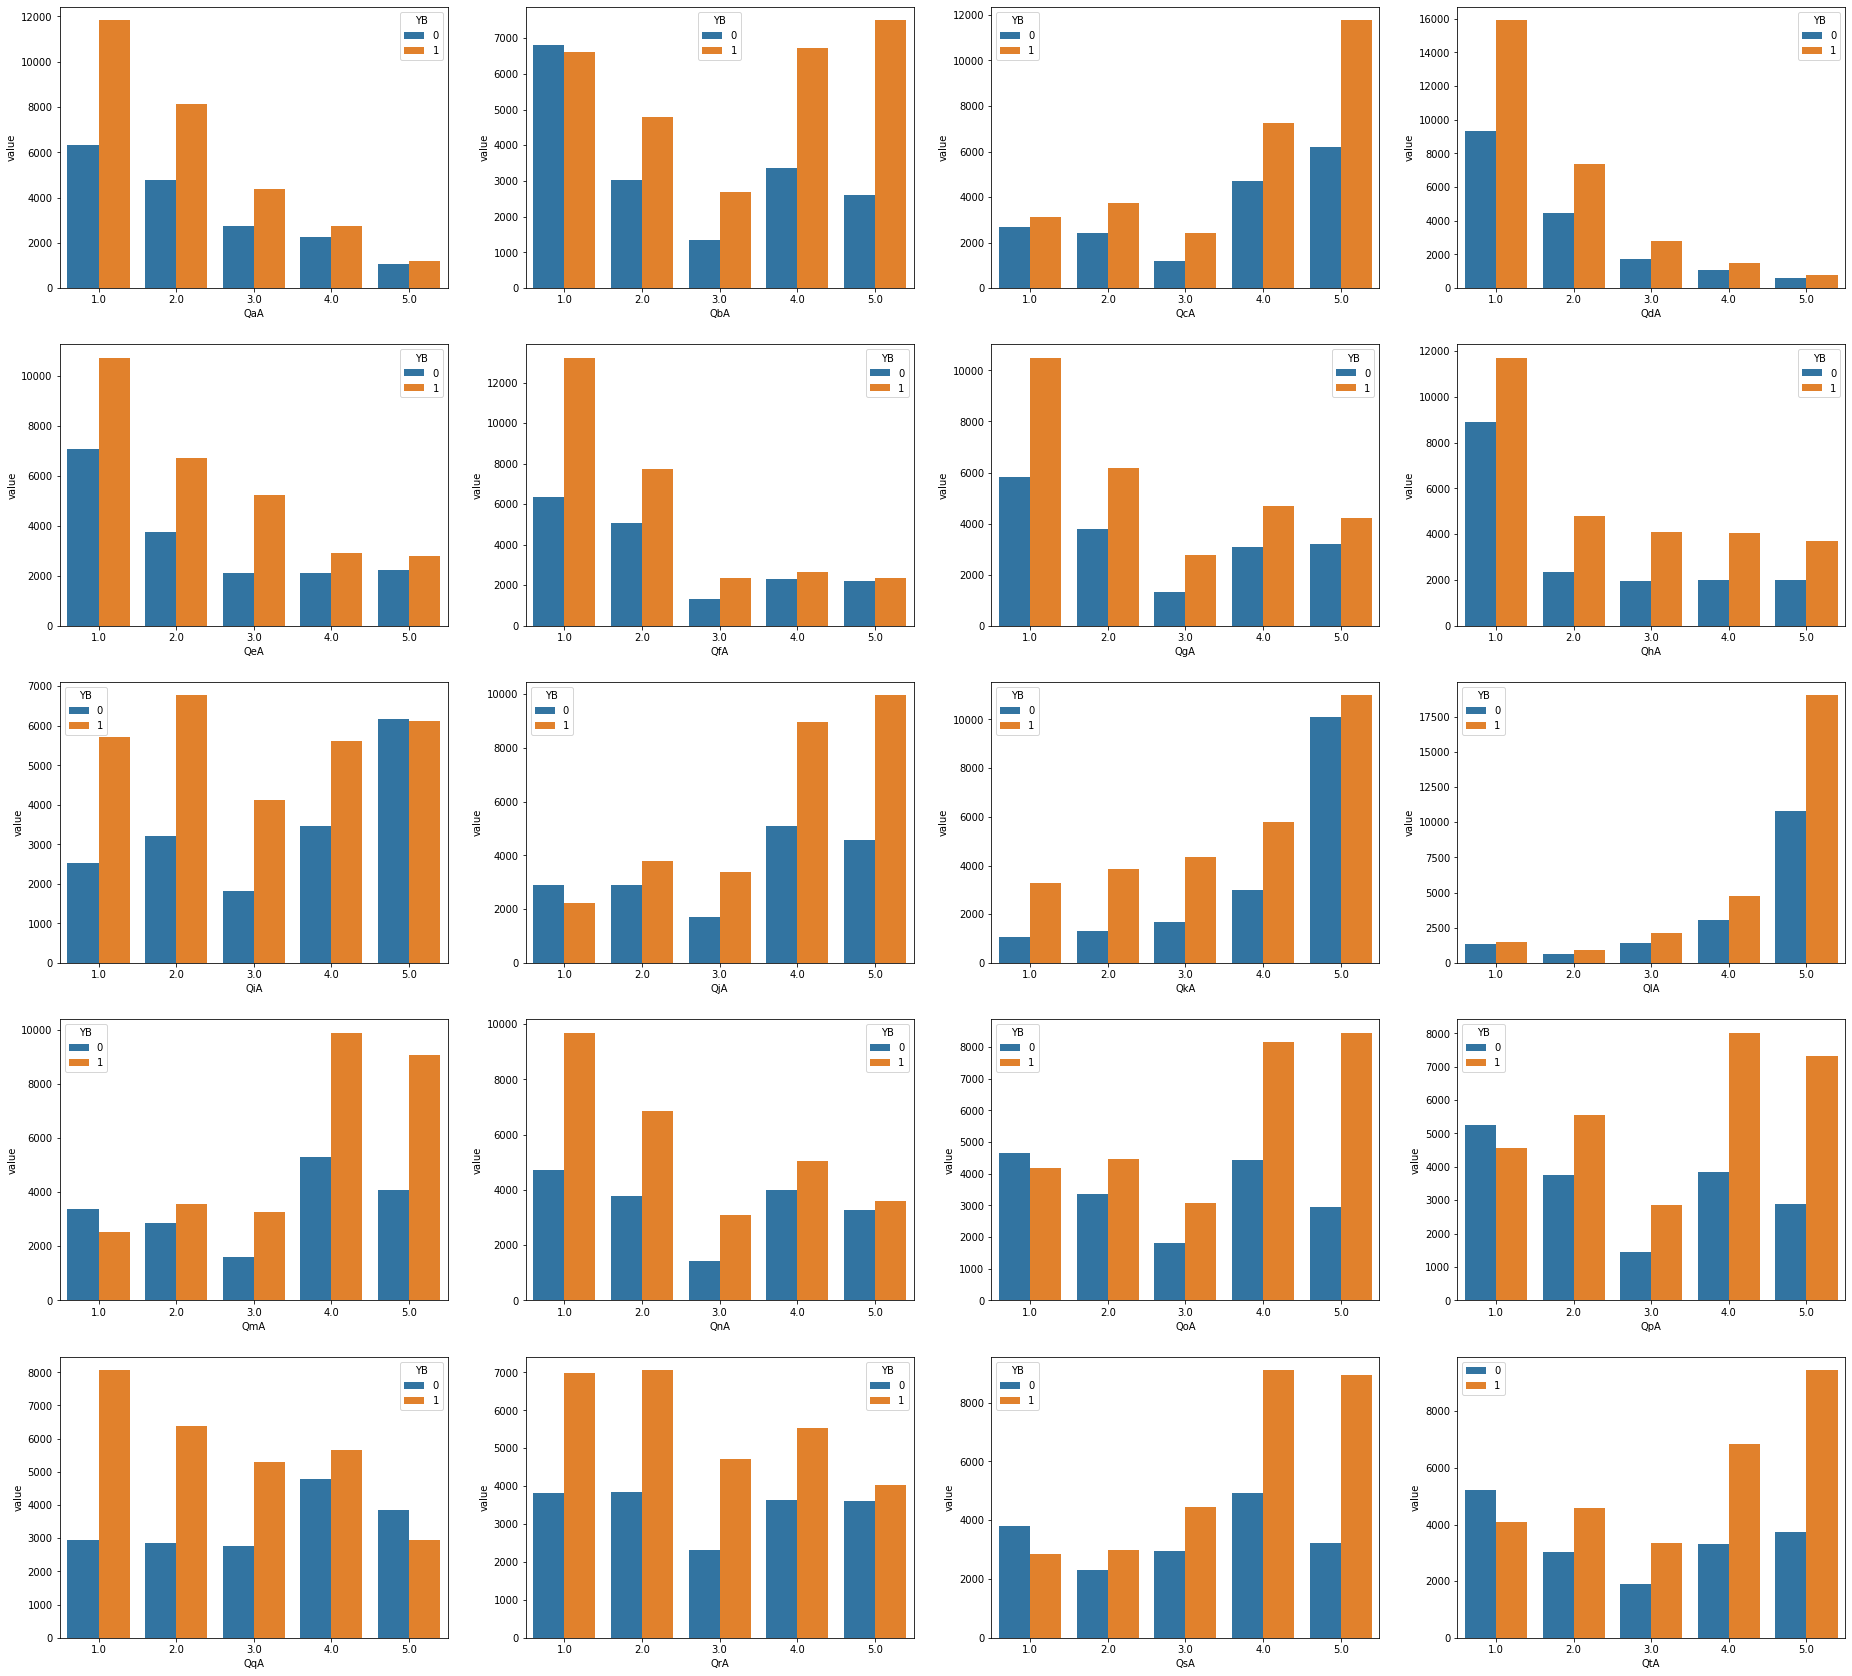

In [13]:
clue_QA(X_train, y_train_proceed)

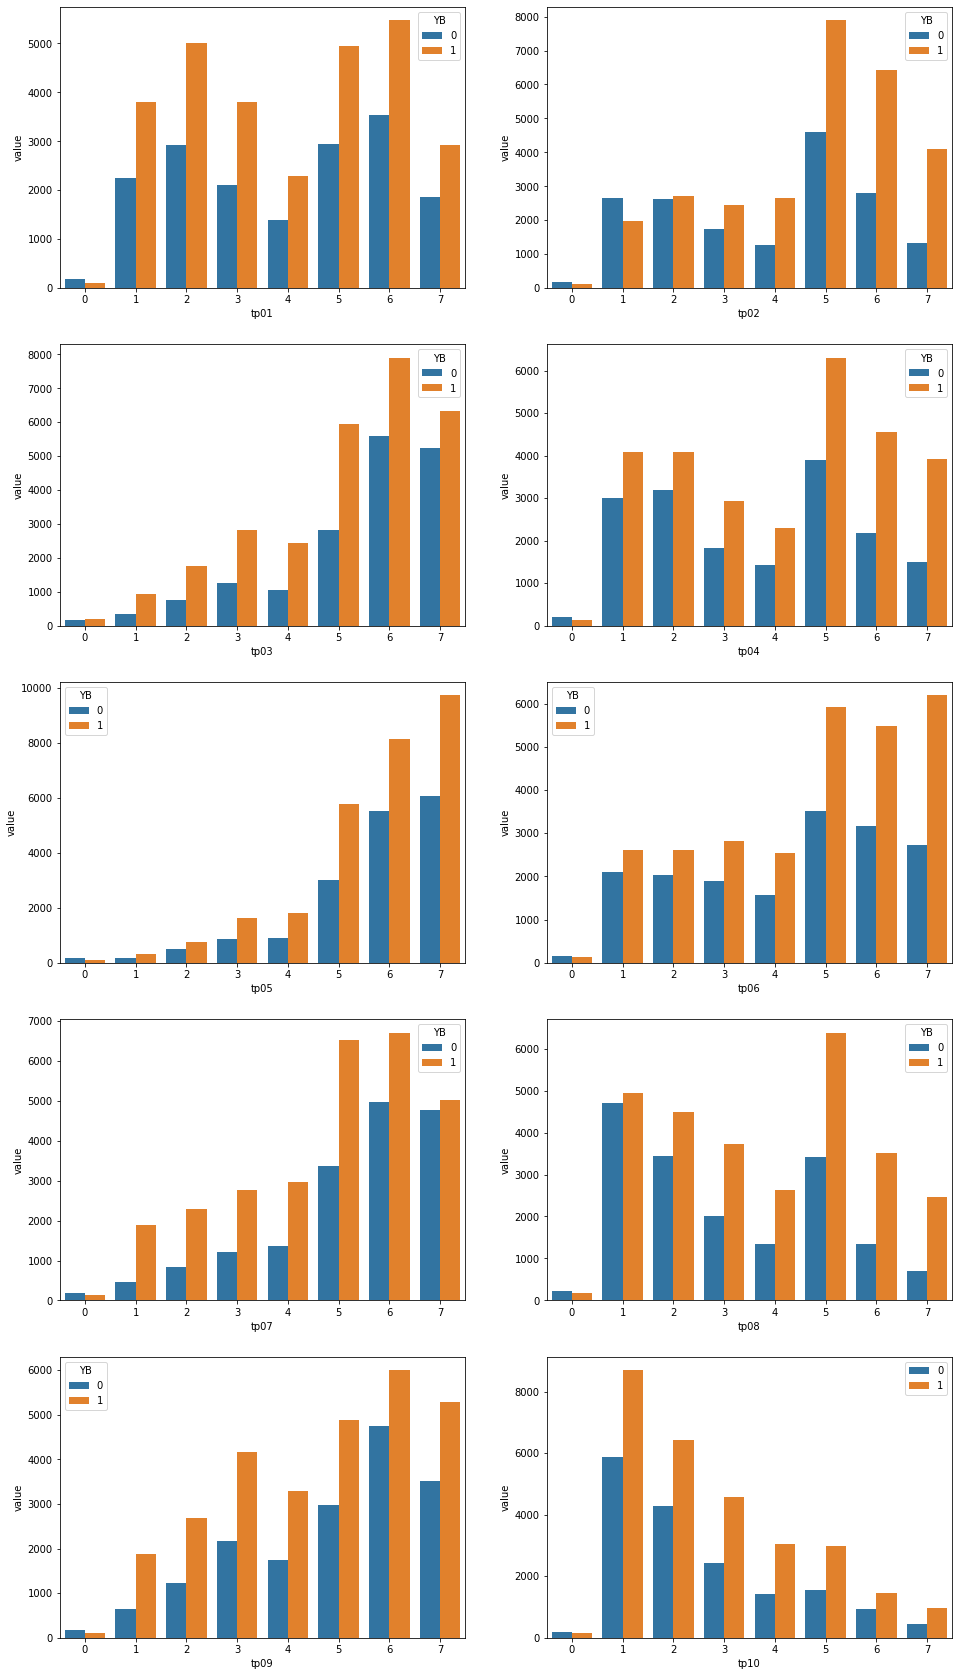

In [14]:
clue_tp(X_train, y_train_proceed)

## PCA 작업

상관관계가 있는 특성들을 PCA를 이용해 차원축소시킨다.

In [15]:
X_train_use, X_dummy, y_train_use, y_dummy = split_undersample(X_train_proceed, y_train_proceed)

In [16]:
zip = [
       find_contains(X_train_use.columns, 'Q*A|tp'),
       find_contains(X_train_use.columns, 'wr|wf')
       ]


X_train_pca = X_train_use.copy()
X_test_pca = X_test_proceed.copy()

pca = make_pipeline(
    StandardScaler(),
    PCA()
)

for col in zip:
  X_train_pca[col] = pca.fit_transform(X_train_use[col])
  X_test_pca[col] = pca.transform(X_test_proceed[col])

for df in [X_train_pca, X_test_pca]:
  df.drop(['married', 'education', 'hand', 'engnat', 'gender', 'race'], axis=1, inplace=True)
  df.drop(find_contains(df.columns, 'Q.E'), axis=1, inplace=True)
  df.drop(columns=zip[1][3:], inplace=True)
#  df.drop(columns=zip2[5:], inplace=True)
#  df.drop(columns=zip3[3:], inplace=True)
  df.drop(columns='wf_02', inplace=True)

#모델 만들기

- baseline 모델을 선정하고 이에 기반해 모델링 성능을 평가합니다.
- 반복적인 Feature Engineering 과정을 통해 모델 성능을 최적화합니다.
- 문제 정의에 맞는 평가 지표를 선택하여 모델의 성능을 설명합니다.
- 교차검증이나 hold-out 기법을 사용해 학습 성능과 일반화 성능을 구분하여 제시합니다.
- 여러 수치적 지표 및 permutation importance, pdp, shap 등을 활용하여 최종모델을 설명합니다. 시각화는 설명이 가장 중요합니다.
- 1에서 제시한 가설을 해결합니다.

## Baseline

In [17]:
pipe = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(random_state=2, n_jobs=-1)
)

clf = GridSearchCV(
    pipe,
    param_grid={
        'xgbclassifier__max_delta_step':[10, 20, 15],
        'xgbclassifier__max_depth':[3,4,5]
    }, scoring='f1', n_jobs=-1, cv=3
)

In [18]:
clf.fit(X_train_pca, y_train_use);

In [19]:
clf.best_score_, clf.best_params_

(0.7447199385958417,
 {'xgbclassifier__max_delta_step': 10, 'xgbclassifier__max_depth': 5})

In [20]:
f1_score(convert_target(y_test), clf.best_estimator_.predict(X_test_pca))

0.7954704319865791

In [21]:
permut = PermutationImportance(
    clf.best_estimator_.named_steps['xgbclassifier'],
    scoring = 'f1',
    n_iter = 5,
    random_state = 2
).fit(clf.best_estimator_.named_steps['ordinalencoder'].transform(X_test_pca), y_test_proceed)

In [22]:
eli5.show_weights(
    permut, 
    top=None,
    feature_names= X_test_pca.columns.tolist()
)

Weight,Feature
0.0441 ± 0.0044,QaA
0.0335 ± 0.0021,wf_01
0.0154 ± 0.0046,wf_03
0.0141 ± 0.0029,QbA
0.0086 ± 0.0024,religion
0.0072 ± 0.0029,QjA
0.0071 ± 0.0026,QdA
0.0061 ± 0.0023,QeA
0.0060 ± 0.0028,QlA
0.0059 ± 0.0033,familysize


In [23]:
explainer = shap.TreeExplainer(clf.best_estimator_.named_steps['xgbclassifier'])
s_values = explainer.shap_values(clf.best_estimator_.named_steps['ordinalencoder'].transform(X_train_pca))

In [25]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=s_values[:300], 
    features=X_train_pca[:300], 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

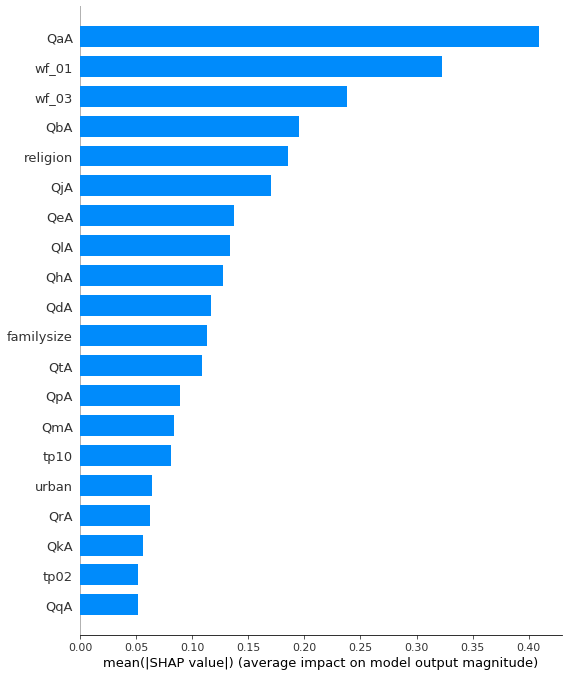

In [26]:
shap.summary_plot(s_values, X_train_pca, plot_type='bar')

In [34]:
def make_pdp_plot(feat:str):
  df = clf.best_estimator_.named_steps['ordinalencoder'].transform(X_train_pca)
  return pdp.pdp_plot(
    pdp.pdp_isolate(
        clf.best_estimator_.named_steps['xgbclassifier'], df,
        model_features= df.columns,
        feature=feat
    ), feature_name=feat
  )
def make_pdp_interact(feat1:str, feat2:str):
  features = [feat1, feat2]
  df = clf.best_estimator_.named_steps['ordinalencoder'].transform(X_train_pca)

  interaction = pdp.pdp_interact(
    model=clf.best_estimator_.named_steps['xgbclassifier'], 
    dataset=df,
    model_features=df.columns, 
    features=features
  )
  return pdp.pdp_interact_plot(
      interaction, plot_type='grid',
      feature_names=features);

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7a07c6d390>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7a09e8db90>})

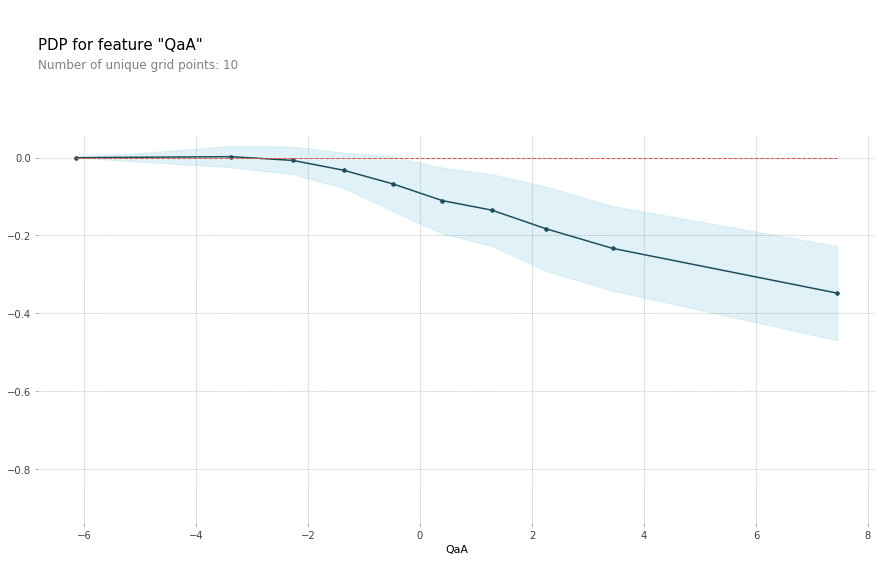

In [35]:
make_pdp_plot('QaA')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7a08014890>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7a07fbdfd0>})

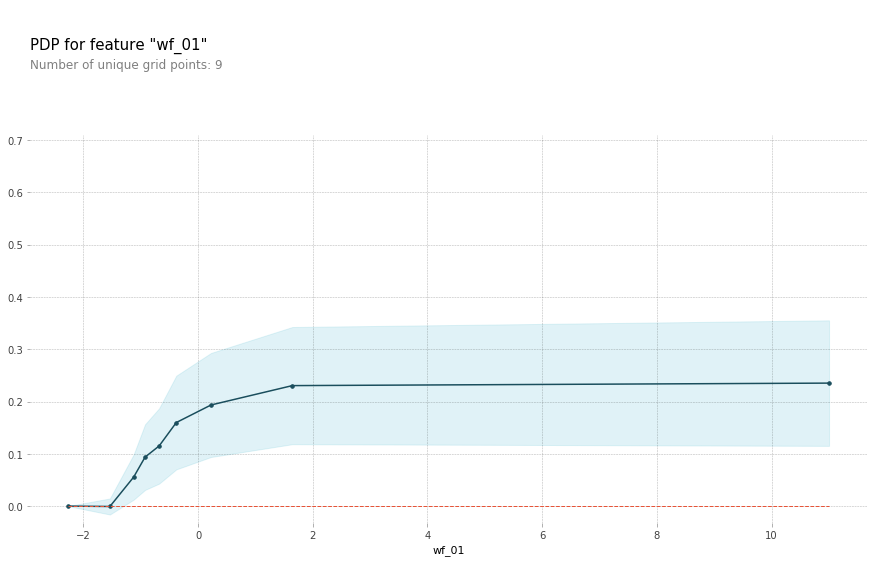

In [36]:
make_pdp_plot('wf_01')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7a08202750>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7a08216610>})

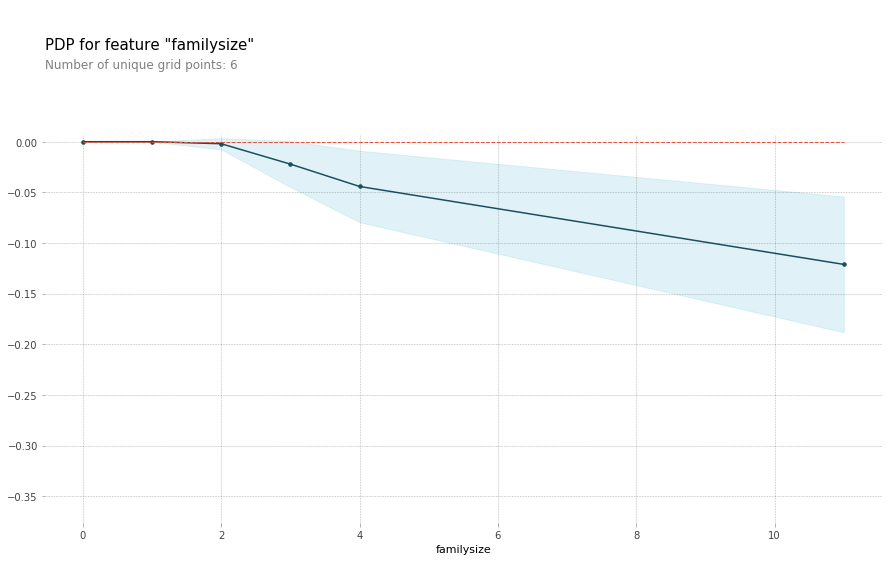

In [37]:
make_pdp_plot('familysize')

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7a081849d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0a31afd0>})

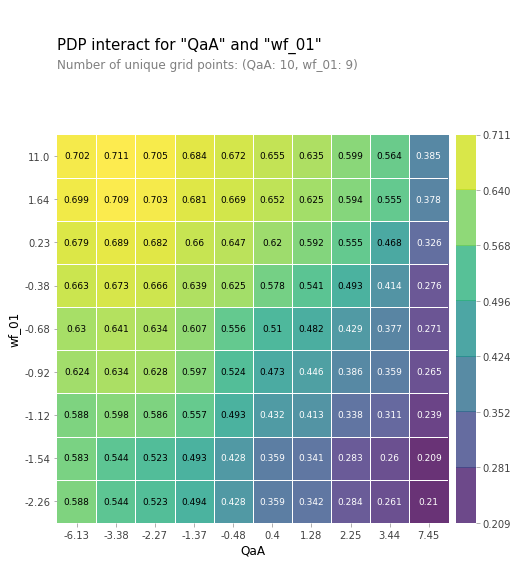

In [38]:
make_pdp_interact('QaA', 'wf_01')